# Анализ вероятности клика на рекламу

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

Используем данные из файла **advertising.csv** с информацией о клиентах интернет-магазина.

В нём содержаться следующие переменные:

| Название переменной | Описание переменной
|:-------------------:|:------------------:|
| Daily Time Spent on Site | consumer time on site in minutes |
| Age | cutomer age in years |
| Area Income | Avg. Income of geographical area of consumer |
| Daily Internet Usage | Avg. minutes a day consumer is on the internet |
| Ad Topic Line | Headline of the advertisement |
| City | City of consumer |
| Male | Whether or not consumer was male |
| Country |	Country of consumer |
| Timestamp | Time at which consumer clicked on Ad or closed window |
| Clicked on Ad | 0 or 1 indicated clicking on Ad |


Создадим модель, которая будет предсказывать, нажмет ли интернет-пользователь на рекламу, на основе характеристик этого пользователя.

### Предварительный анализ

In [2]:
df = pd.read_csv('advertising.csv')
df

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
...,...,...,...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,2016-02-11 21:49:00,1
996,51.30,45,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,2016-04-22 02:07:01,1
997,51.63,51,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,2016-02-01 17:24:57,1
998,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,2016-03-24 02:35:54,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.3+ KB


In [4]:
df.isna().sum()

,0
Daily Time Spent on Site,0
Age,0
Area Income,0
Daily Internet Usage,0
Ad Topic Line,0
City,0
Male,0
Country,0
Timestamp,0
Clicked on Ad,0


In [5]:
for name in df.dtypes.unique():
    print('Type: {}\n{}\n'.format(name, df.dtypes[df.dtypes==name].index.values))

Type: float64
['Daily Time Spent on Site' 'Area Income' 'Daily Internet Usage']

Type: int64
['Age' 'Male' 'Clicked on Ad']

Type: object
['Ad Topic Line' 'City' 'Country' 'Timestamp']



#### Сформулируем гипотезы, которые будут проверены в ходе исследования.

Создадим категориальную переменную Income Quartile, которая будет принимать значения 1-4 в зависимости от того в какой квартиль входит по доходу человек, где 4 - самый высокий доход, 1 - самый низкий.

In [6]:
df['Income Quartile'] = pd.qcut(df['Area Income'], q=4, labels=['1','2','3','4'])
df[['Area Income', 'Income Quartile']]

,Area Income,Income Quartile
0,61833.90,3
1,68441.85,4
2,59785.94,3
3,54806.18,2
4,73889.99,4
...,...,...
995,71384.57,4
996,67782.17,4
997,42415.72,1
998,41920.79,1


Сформулируем пять гипотез:

1. Daily Time Spent on Site (Время на сайте)
$H_0$: Время, проведенное на сайте, не оказывает влияния на вероятность клика.
$H_1$: Существует статистически значимая связь между временем на сайте и вероятностью клика.

2. Daily Internet Usage (Использование интернета)
$H_0$: Интенсивность ежедневного использования интернета не связана с вероятностью клика.
$H_1$: Существует значимая зависимость между суточным потреблением интернет-трафика и вероятностью того, что пользователь нажмет на рекламное объявление.

3. Age (Возраст)
$H_0$: Возраст пользователя не влияет на кликабельность рекламы.
$H_1$: Вероятность клика статистически значимо меняется в зависимости от возраста пользователя.

4. Male (Пол)
$H_0$: Вероятность клика не зависит от пола пользователя (различия между мужчинами и женщинами отсутствуют).
$H_1$: Пол пользователя является значимым предиктором, и вероятность клика у мужчин и женщин статистически различается.

5. Income Quartile (Квартиль дохода)
$H_0$: Уровень дохода пользователя (принадлежность к определенному квартилю) не влияет на решение кликнуть по рекламе.
$H_1$: Существуют статистически значимые различия в поведении пользователей, относящихся к разным категориям дохода.

#### Построем модель бинарной логистической регрессии. Зависимая переменная – Clicked on Ad. В качестве предикторов выберем 3 метрических переменных и 2 категориальных переменных, которые описаны в прошлом пункте. Выпишем уравнение регрессии (линейная часть). Охарактеризуем регрессионную модель. Оценим статическую значимость и предсказательную силу модели. Построем ROC-кривую. Рассчитаем площадь под ROC-кривой и некоторые другие метрики.

Выбранные предикторы упомянуты в прошлом пункте с указанием того, какого типа каждая переменная

Сделаем из категориальных переменных дамми-переменные

In [7]:
Income_Quartile_dummies = pd.get_dummies(df['Income Quartile'], prefix='Income_Quartile', prefix_sep='_', dtype=int)
Income_Quartile_dummies # референтная группа - 1, группа с наименьшим дохожом

,Income_Quartile_1,Income_Quartile_2,Income_Quartile_3,Income_Quartile_4
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,0,1,0,0
4,0,0,0,1
...,...,...,...,...
995,0,0,0,1
996,0,0,0,1
997,1,0,0,0
998,1,0,0,0


In [8]:
df['Male'].value_counts() # Референтная группа - 0, женщины

,count
Male,
0,519
1,481


Добавляем в датафрейм дамми-переменные

In [9]:
df = pd.concat([df, Income_Quartile_dummies], axis=1)
df

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Income Quartile,Income_Quartile_1,Income_Quartile_2,Income_Quartile_3,Income_Quartile_4
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,3,0,0,1,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,4,0,0,0,1
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,3,0,0,1,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,2,0,1,0,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,4,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,2016-02-11 21:49:00,1,4,0,0,0,1
996,51.30,45,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,2016-04-22 02:07:01,1,4,0,0,0,1
997,51.63,51,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,2016-02-01 17:24:57,1,1,1,0,0,0
998,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,2016-03-24 02:35:54,0,1,1,0,0,0


Сделаем предварительный анализ взаимосвязей предикторов с зависимой переменной

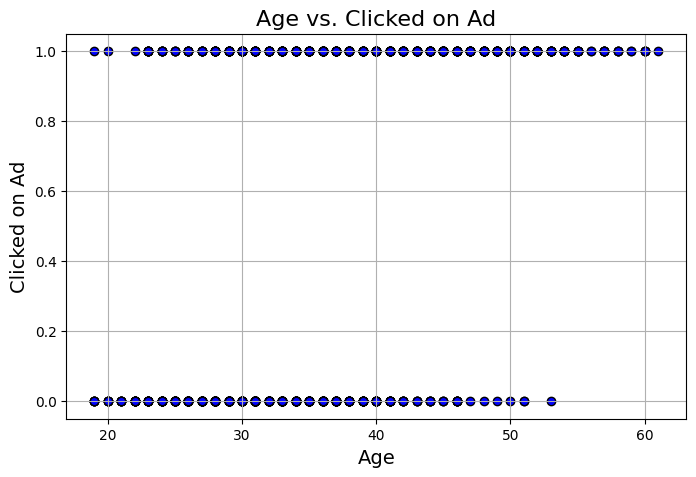

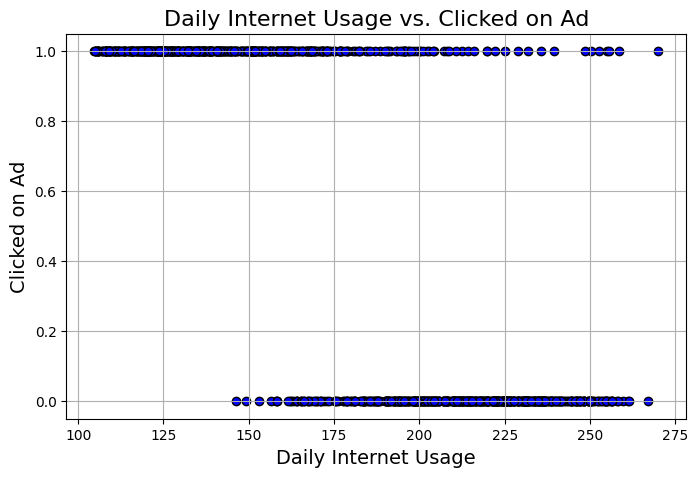

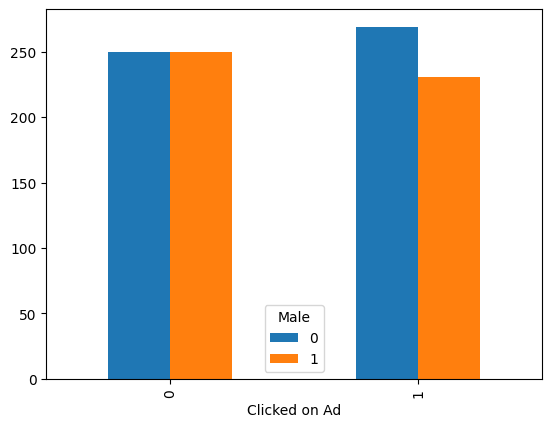

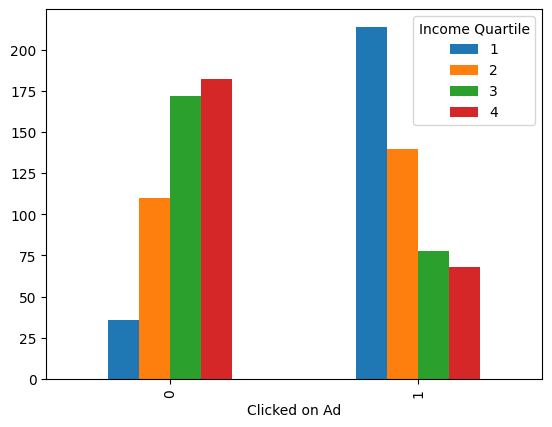

In [10]:
for c in df.columns[1:]:
    if c == 'Age' or c == 'Daily Time Spent on Site' or c == 'Daily Internet Usage':
        plt.figure(figsize=(8,5))
        plt.title('{} vs. Clicked on Ad'.format(c), fontsize=16)
        plt.scatter(x=df[c], y=df['Clicked on Ad'], color='blue',edgecolor='k')
        plt.grid(True)
        plt.xlabel(c, fontsize=14)
        plt.ylabel('Clicked on Ad', fontsize=14)
        plt.show()
    elif c == 'Male' or c == 'Income Quartile':
        ct = pd.crosstab(df['Clicked on Ad'], df[c])
        ct.plot.bar()

In [11]:
x_mult = df[['Age', 'Daily Time Spent on Site', 'Daily Internet Usage', 'Male', 'Income_Quartile_2', 'Income_Quartile_3', 'Income_Quartile_4']]
y = df['Clicked on Ad']
x_mult_constant = sm.add_constant(x_mult)

Построим модель логистической регрессии для предсказания 'Clicked on Ad' на основе предикторов 'Age', 'Daily Time Spent on Site', 'Daily Internet Usage', 'Male', 'Income_Quartile_2', 'Income_Quartile_3', 'Income_Quartile_4'

In [12]:
model1 = sm.Logit(y, x_mult_constant).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.095180
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:          Clicked on Ad   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      992
Method:                           MLE   Df Model:                            7
Date:                Fri, 30 Jan 2026   Pseudo R-squ.:                  0.8627
Time:                        20:35:37   Log-Likelihood:                -95.180
converged:                       True   LL-Null:                       -693.15
Covariance Type:            nonrobust   LLR p-value:                5.348e-254
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       21.7457      2.223      9.781      0.000      17.38

In [13]:
print('R^2 = {:f}'.format(model1.prsquared))
print('Model significance = {:f}'.format(model1.llr_pvalue))

R^2 = 0.862684
Model significance = 0.000000


Влияние каждого предиктора и их статистическую значимость рассмотрим в следующем пункте

Модель статистически значима и объясняет 86% изменчивости значений зависимой переменной

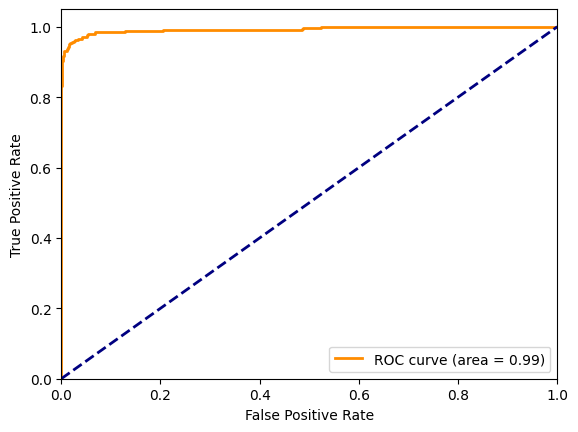

In [14]:
fpr, tpr, _ = roc_curve(y, model1.predict())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Площадь под кривой 0,99, что указывает на то, что модель почти идеально различает пользователей, которые кликнули на рекламу и пользователей, которые не кликнули

Дополнительно посчитаем другие метрики

In [15]:
y_prob = model1.predict()
y_pred = (y_prob >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.967
Precision: 0.9755600814663951
Recall: 0.958


Модель показывает высокие показатели на всех метриках

#### Оценим статистическую значимость регрессионных коэффициентов. Опишем особенности взаимосвязи между каждым из предикторов и зависимой переменной на основе значений регрессионных коэффициентов.

In [16]:
coefs = pd.DataFrame()
coefs['Coefs'] = model1.params[1:]
coefs['Features'] = model1.params.index[1:]
coefs.set_index('Features', inplace=True)
print('Intercept = ', model1.params[0])
coefs # коэффициенты регрессии

Intercept =  21.745730262660555


,Coefs
Features,
Age,0.180233
Daily Time Spent on Site,-0.198577
Daily Internet Usage,-0.063148
Male,-0.573330
Income_Quartile_2,-0.684709
Income_Quartile_3,-2.733925
Income_Quartile_4,-4.279344


In [17]:
coefs['OddsRatio'] = np.exp(coefs.Coefs)
coefs # коэффициенты регрессии и отношения шансов

,Coefs,OddsRatio
Features,,
Age,0.180233,1.197496
Daily Time Spent on Site,-0.198577,0.819897
Daily Internet Usage,-0.063148,0.938804
Male,-0.573330,0.563645
Income_Quartile_2,-0.684709,0.504237
Income_Quartile_3,-2.733925,0.064964
Income_Quartile_4,-4.279344,0.013852


In [18]:
def yes_no(p_value, level = 0.05):
    if abs(p_value) < level:
        return 'significant'
    else:
        return 'non-significant'

In [19]:
pvals = pd.DataFrame()
pvals['p_values'] = model1.pvalues[1:]
pvals['5% level']= pvals['p_values'].apply(yes_no)
pvals['p_values'] = pvals['p_values'].map('{:.3f}'.format)
pvals['Features'] = model1.params.index[1:]
pvals['10% level'] = model1.pvalues[1:].apply(lambda x: yes_no(x, level=0.1))
pvals.set_index('Features',inplace=True)
pvals

,p_values,5% level,10% level
Features,,,
Age,0.000,significant,significant
Daily Time Spent on Site,0.000,significant,significant
Daily Internet Usage,0.000,significant,significant
Male,0.148,non-significant,non-significant
Income_Quartile_2,0.227,non-significant,non-significant
Income_Quartile_3,0.000,significant,significant
Income_Quartile_4,0.000,significant,significant


Ниже столбцы статистические значимые и не значимые соответственно на уровне значимости 0.05

In [20]:
print(f'Статистически значимые предикторы: {model1.pvalues[model1.pvalues < 0.05].index.values}')

Статистически значимые предикторы: ['const' 'Age' 'Daily Time Spent on Site' 'Daily Internet Usage'
 'Income_Quartile_3' 'Income_Quartile_4']


In [21]:
print(f'Статистически не значимые предикторы: {model1.pvalues[model1.pvalues > 0.05].index.values}')

Статистически не значимые предикторы: ['Male' 'Income_Quartile_2']


In [22]:
first = model1.params.iloc[0]
l = []

for (param, index) in zip(model1.params[1:], model1.params.index[1:]):
    l.append('{:.2f}*{}'.format(param, index))

print(f"logit(p) = {first} + " + " + ".join(l).replace("+ -", "- "))

logit(p) = 21.745730262660555 + 0.18*Age - 0.20*Daily Time Spent on Site - 0.06*Daily Internet Usage - 0.57*Male - 0.68*Income_Quartile_2 - 2.73*Income_Quartile_3 - 4.28*Income_Quartile_4


При увеличении возраста на год на 20% увеличивается шанс клика на рекламу. Увеличение ежедневного времени на сайте уменьшает шанс клика на 18%. Увеличение ежедневного времени использования интернета уменьшает шанс клика на 6%. Мужчины на 44% реже кликают на рекламу, чем женщины. Шанс клика уменьшается с ростом дохода: пользователи из второго квартиля на 50% реже кликают на рекламу, чем референтная группа (пользователи из первого квантиля), пользователи из третьего квартиля на 94% реже кликают, чем референтная группа и пользователи из четвертого квартиля на 99% реже кликают на рекламу, чем референтная группа.


#### Проведём диагностику модели (проверим остатки, оценим мультиколлинартность). Проведём кросс-валидацию модели и опишем результаты.

In [23]:
p = stats.kstest(model1.resid_generalized, 'norm', args=(model1.resid_generalized.mean(), model1.resid_generalized.std())).pvalue
print('P-value: {:.3f}'.format(p))

P-value: 0.000


<Axes: ylabel='Density'>

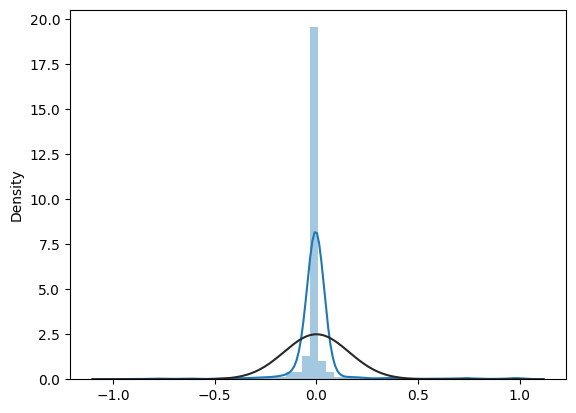

In [24]:
sns.distplot(model1.resid_generalized, fit=stats.norm)

Распределение остатков отличается от нормального

In [25]:
vifs = np.array([vif(model1.model.exog, i) for i in range(model1.model.exog.shape[1])])

In [26]:
vif_df = pd.DataFrame()
vif_df['VIF'] = vifs[1:]
vif_df['Features'] = model1.params.index[1:]
vif_df.sort_values(by=['VIF'])

,VIF,Features
3,1.013057,Male
0,1.218086,Age
1,1.463776,Daily Time Spent on Site
2,1.528075,Daily Internet Usage
4,1.588766,Income_Quartile_2
6,1.707341,Income_Quartile_4
5,1.737943,Income_Quartile_3


Значений VIF больше 10 нет, значит проблема мультиколлинеарности отсутствует

### Кросс-валидация

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_mult, y, test_size=0.2, random_state=0)

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty=None)
lr.fit(X_train, y_train)
pred = lr.predict(X_train)
clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
print("Train Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

Train Result:
Accuracy Score: 96.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.959494    0.967901   0.96375    0.963697      0.963782
recall       0.966837    0.960784   0.96375    0.963811      0.963750
f1-score     0.963151    0.964330   0.96375    0.963740      0.963752
support    392.000000  408.000000   0.96375  800.000000    800.000000
_______________________________________________
Confusion Matrix: 
 [[379  13]
 [ 16 392]]



In [29]:
pred = lr.predict(X_test)
clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))

print("Test Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

Test Result:
Accuracy Score: 97.50%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.963964   0.988764     0.975    0.976364      0.975372
recall       0.990741   0.956522     0.975    0.973631      0.975000
f1-score     0.977169   0.972376     0.975    0.974772      0.974964
support    108.000000  92.000000     0.975  200.000000    200.000000
_______________________________________________
Confusion Matrix: 
 [[107   1]
 [  4  88]]



Дополнительно используем метод опорных векторов для предсказания в задаче классификации

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Разделяем выборку на трейн и тест, используем линейный SVM в качестве ядра

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x_mult, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

Предсказываем классы и вероятности на тестовой выборке

In [32]:
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]

Считаем метрики

In [33]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.935
Confusion Matrix:
 [[ 85   4]
 [  9 102]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93        89
           1       0.96      0.92      0.94       111

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200



Построим ROC-кривую для определения насколько хорошо SVM определяет классы

In [34]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

AUC: 0.9797550359348111


Площадь почти 1, значит определение классов почти идеальное

#### Сформулируем общие выводы по результатам регрессионного анализа данных.

В прошлых пунктах мы описали результаты модели и влияние каждого фактора на шанс клика. Для меня оказалось неожиданным, что на шанс клика очень влияет пол человека, а также то, что и увелечение времени на сайте, и увелечение времени в интернете только уменьшает шанс клика. Ожидаемо было, то, что люди с большим доходом будут меньше кликать на рекламу, также было ожидаемо, что с увеличением возраста люди будут чаще кликать на рекламу.